In [1]:
# Packages for modeling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ternary
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
from tqdm import tqdm
from scipy.stats import norm

# Packages for visualization

from skmatter.decomposition import KernelPCovR, PCovR
from skmatter.preprocessing import StandardFlexibleScaler

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

from sklearn.manifold import TSNE

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Uncertainty Weighting

epsilon = 0 # Default = 0; Adds allowance for minimum Expected Improvement that will be recommended (additive). Increasing this will mean that EI can be lower and still recommend points which will favor exploration.
weight = 1 # Default = 1; Weights the value of prediction uncertainty for expected improvment (multiplicative)

Num_of_recs = 5 # Select desired number of recommendations

In [4]:
Data =  pd.read_excel('../Data/Predicted Data/All Points CE Predictions for each iteration/all_predictions_7th_iteration.xlsx', engine='openpyxl')

Initial =  pd.read_excel('../Data/Experimental Data/Initial.xlsx', engine='openpyxl')
Initial['<CE> (%)'] = np.log10(np.reciprocal(1 - (Initial['<CE> (%)']/100)))

Gaus_data = Data[['Predicted CE', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']][:-14].dropna()
Gaus_data['CE'] = Gaus_data['Predicted CE'] 

Gaus_data['<CE> (%)'] = np.log10(np.reciprocal(1 - (Gaus_data['CE']/100))) # Log scaling

Plotting_points = pd.read_excel('../Data/Data Space/0.1 Mole Interval.xlsx', engine='openpyxl', index_col=0) # Read in by 0.1 for plotting
Rec_points = Gaus_data[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]

In [5]:
Y_scale = StandardScaler()
X_scale = StandardScaler()

Plotting_points_scaled = X_scale.fit_transform(Plotting_points) # Scale data space for GP modeling

X = X_scale.transform(Gaus_data[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]) # Collected data transformed for GP modeling
X_unscaled = Gaus_data[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']] # Collected data without CE %

Rec_points_scaled = X.copy()

Y = Y_scale.fit_transform(Gaus_data[['<CE> (%)']]) # Scale for GP regression target

TSNE_ec = TSNE(n_components=2,init='pca',random_state=90, angle = 0.3, perplexity=150, n_iter=250)

Space_tsne = TSNE_ec.fit_transform(Plotting_points[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']])
tsne_result = pd.DataFrame(data = Space_tsne , columns=["TC1","TC2"]).reset_index(drop=True)

space_labeled = Plotting_points.copy()
space_labeled['TC1'], space_labeled['TC2'] = tsne_result['TC1'], tsne_result['TC2']

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


# Loop

100%|██████████| 5/5 [00:00<00:00, 336.21it/s]
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|██████████| 5/5 [00:30<00:00,  6.11s/it]
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|██████████| 5/5 [00:30<00:00,  6.07s/it]
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/3061908441.py:156: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
/var/folders/n0/8fxhskld1wsc76dqz

TSNE


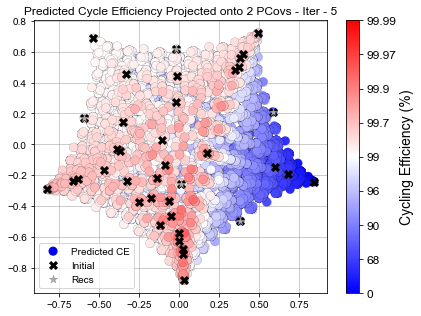

In [32]:
#X_start = Gaus_data.sample(n=10, random_state=0)
#X_start = Gaus_data.loc[((Gaus_data == 1).sum(axis=1) == 1)]
X_start = Initial.copy()
X_s = X_scale.transform(X_start[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]) # Collected data transformed for GP modeling
Y_s = Y_scale.transform(X_start[['<CE> (%)']]) # Scale for GP regression target

Num_of_loops = 6
for L in range(Num_of_loops):

    # Define GP model
    kernel_b = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
    Kernel = 1 * Matern(length_scale=1, length_scale_bounds=(0.1, 2), nu=1.5) + Wht(1.0, (1e-6, 1000))
    kernel_lit = C(1.0, (1e-3,1e3)) * matk([1.0]*10,[[1e-12, 1e18]]*10,1.5) + Wht(1.0, (1e-6, 1e3))
    Gaus_model = GaussianProcessRegressor(kernel=kernel_lit, n_restarts_optimizer=30, random_state=234)
    Gaus_model.fit(X_s,Y_s)

    # Predict CE and Uncertainty
    Pred, Std = Gaus_model.predict(Plotting_points_scaled, return_std = True)
    Pred_Next, Std_Next = Gaus_model.predict(Rec_points_scaled, return_std = True)
    ybest = X_start['<CE> (%)'].max()

    zzval=((Pred-ybest-epsilon)/Std)
    expI=(Pred-ybest-epsilon)*norm.cdf(zzval)+Std*norm.pdf(zzval)*weight

    for i in range(0,expI.shape[0]):
        if Std[i] < 0:
            expI[i] = 0

    # Get EI for next loop
    zzval_Next=((Pred_Next-ybest)/Std_Next)
    expI_Next=(Pred_Next-ybest-epsilon)*norm.cdf(zzval_Next)+Std_Next*norm.pdf(zzval_Next)*weight

    for i in range(0,expI_Next.shape[0]):
        if Std_Next[i] < 0:
            expI_Next[i] = 0

    # Copying data, predicting, and creating a sorted dataframe for plotting points
    Plotting_points_pred = Plotting_points.copy()
    Plotting_points_pred['Predicted CE'], Plotting_points_pred['Log Predicted CE StD'], Plotting_points_pred['Expected Improvement'] = (1-np.reciprocal(10**Y_scale.inverse_transform(Pred.reshape(-1, 1))))*100, Y_scale.inverse_transform(Std.reshape(-1, 1)) - Y_scale.mean_[0], expI.reshape(-1,1)
    Plotting_points_pred_sorted = Plotting_points_pred.copy().sort_values(by='Expected Improvement', ascending=True)

    # Copying data, predicting, and creating a sorted dataframe for recommending points
    Rec_points_pred = Rec_points.copy()
    Rec_points_pred['Predicted CE'], Rec_points_pred['Log Predicted CE StD'], Rec_points_pred['Expected Improvement'] = (1-np.reciprocal(10**Y_scale.inverse_transform(Pred_Next.reshape(-1, 1))))*100, Y_scale.inverse_transform(Std_Next.reshape(-1, 1)) - Y_scale.mean_[0], expI_Next.reshape(-1,1)
    Rec_points_pred_sorted = Rec_points_pred.copy().sort_values(by='Expected Improvement', ascending=True)

    # Creating dataset for farthest point sampling if needed
    FPS_Select_Scaled = pd.DataFrame(Rec_points_scaled, columns=Rec_points.columns) # Farthest point sampling in case it is needed later
    FPS_Select_Scaled['Predicted CE'], FPS_Select_Scaled['Log Predicted CE StD'], FPS_Select_Scaled['Expected Improvement'] = Y_scale.inverse_transform(Pred_Next.reshape(-1, 1)), Y_scale.inverse_transform(Std_Next.reshape(-1, 1)) - Y_scale.mean_[0], expI_Next.reshape(-1,1)

    # Check how many points are tied for the maximum EI and create data frame
    Maximum_EI_df = FPS_Select_Scaled.loc[np.round(Rec_points_pred['Expected Improvement'],3) == np.round(Rec_points_pred['Expected Improvement'].max(), 3)].copy().drop(['Predicted CE', 'Log Predicted CE StD', 'Expected Improvement'], axis=1).reset_index(drop=True)
    Maximum_EI_df_full = Rec_points_pred.loc[np.round(Rec_points_pred['Expected Improvement'],3) == np.round(Rec_points_pred['Expected Improvement'].max(), 3)].copy().reset_index(drop=True)

    # Break ties with furthest point sampling
    if Maximum_EI_df.shape[0] > Num_of_recs:

        FPS_points_full = Rec_points_pred.loc[Rec_points_pred['Expected Improvement'] == Rec_points_pred['Expected Improvement'].max()].copy().iloc[0:1]

        FPS_points = pd.DataFrame(X_s, columns=Plotting_points.columns)

        for i in tqdm(range(0,Num_of_recs)):
            distances = np.zeros(Maximum_EI_df.shape[0])
            for j in range(0,Maximum_EI_df.shape[0]):
                temp = Maximum_EI_df.iloc[j].to_numpy().reshape(1,10) - FPS_points  
                distances[j] = np.min(np.sum(np.square(temp), axis=1))
            max_idx = np.argmax(distances)
            FPS_points = pd.concat((FPS_points, Maximum_EI_df.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

            FPS_points_full = pd.concat((FPS_points_full, Maximum_EI_df_full.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

        Recs = FPS_points_full.reset_index(drop=True).iloc[-Num_of_recs:].sort_values(by='Expected Improvement', ascending=False).reset_index(drop=True)
            
    else:
        Recs = Rec_points_pred_sorted.iloc[-Num_of_recs:].sort_values(by='Expected Improvement', ascending=False).reset_index(drop=True)

    #Recs.to_excel('Robustness Test/Recs - ' + 'epsilon ' + str(epsilon) + ' weight ' + str(weight) + ' Iter - '+str(L)+'.xlsx')


    # Generate top 3 predictions:

    #all points sorted by CE, equivalent to Rec_points_pred_sorted
    CE_sortlist = Rec_points_pred.copy().sort_values(by='Predicted CE', ascending=True)

    #df of scaled parameter space for the compositions with max CE,
    Maximum_CE_df_full = Rec_points_pred.loc[np.round(Rec_points_pred['Predicted CE'],3) == np.round(Rec_points_pred['Predicted CE'].max(), 3)].copy().reset_index(drop=True)

    #above df with predictions dropped
    Maximum_CE_df = Maximum_CE_df_full.copy().drop(['Predicted CE', 'Log Predicted CE StD', 'Expected Improvement'], axis=1).reset_index(drop=True)

    if Maximum_CE_df.shape[0] > 3: #if there are more than 3 top entries, proceed with FPS

        FPS_points_full = Rec_points_pred.loc[Rec_points_pred['Predicted CE'] == Rec_points_pred['Predicted CE'].max()].copy().iloc[0:1]

        FPS_points = pd.DataFrame(X, columns=Plotting_points.columns)

        for i in tqdm(range(0,3)):
            distances = np.zeros(Maximum_CE_df.shape[0])
            for j in range(0,Maximum_CE_df.shape[0]):
                temp = Maximum_CE_df.iloc[j].to_numpy().reshape(1,10) - FPS_points  
                distances[j] = np.min(np.sum(np.square(temp), axis=1))
            max_idx = np.argmax(distances)
            FPS_points = pd.concat((FPS_points, Maximum_CE_df.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

            FPS_points_full = pd.concat((FPS_points_full, Maximum_CE_df_full.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

        top3Recs = FPS_points_full.reset_index(drop=True).iloc[-3:].sort_values(by='Predicted CE', ascending=False).reset_index(drop=True)
            
    else:
        top3Recs = CE_sortlist.iloc[-3:].sort_values(by='Predicted CE', ascending=False).reset_index(drop=True)

    # print(top3Recs)

    # Export Recs
    top3Recs.to_excel('../Data/Robustness Test/top3 - Iter - '+str(L)+'.xlsx')

    # Visualize
    # Fit tSNE (tSNE)

    X_start = pd.concat((X_start,Recs.merge(Gaus_data, on=['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL'])))

    X_s = X_scale.transform(X_start[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]) # Collected data transformed for GP modeling
    Y_s = Y_scale.transform(X_start[['<CE> (%)']]) # Scale for GP regression target

print('TSNE')


# Transform data
T_pcovr_df =  space_labeled[["TC1","TC2"]].copy()

T_pcovr_df['CE'] = Y_scale.inverse_transform(Pred.reshape(-1, 1))

T_pcovr_df = T_pcovr_df.sort_values(by='CE', ascending=True)

X_pcovr_df = X_start.copy().merge(space_labeled, on = ['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL'])

Rec_pcovr_df = Recs.merge(space_labeled, on = ['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL'])

# Export PCovR Axes
#pd.DataFrame(data={'Component': Recs.columns[:10], 'PCov1': pcovr.components_[0], 'PCov2': pcovr.components_[1]}).to_excel('PCovR Components.xlsx')

fig,ax=plt.subplots(1,figsize=(6,4.5), facecolor='white')
ax.grid(color='gray',axis='both',alpha=0.5)
ax.set_axisbelow(True)

cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(T_pcovr_df['TC1'], T_pcovr_df['TC2'], s=80, c='white', edgecolors='k', linewidths=0.1, vmax = 102, vmin = 98, alpha=1)


#sd2 = plt.scatter(X_pcovr_df['PC1'][24:50], X_pcovr_df['PC2'][24:50], s=16, c='None', edgecolors='k', linewidths=0.5, marker='^', label='1st Iter')
sd3 = plt.scatter(T_pcovr_df['TC1'], T_pcovr_df['TC2'], s=80, c=T_pcovr_df['CE'], edgecolors='k', linewidths=0.1, marker='o', label='Predicted CE', vmax=4, vmin=0, cmap='bwr')

cbar = plt.colorbar(location='right', shrink = 1, pad=0.05)
cbar.set_label(label='Cycling Efficiency (%)', size=14)
cbar.ax.set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
cbar.ax.set_yticklabels(['0', '68', '90', '96', '99', '99.7', '99.9', '99.97', '99.99'])
cbar.ax.tick_params(labelsize=12)

#sd = plt.scatter(X_pcovr_df['PC1'][24:], X_pcovr_df['PC2'][24:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s')
sd1 = plt.scatter(X_pcovr_df['TC1'][:100], X_pcovr_df['TC2'][:100], s=80, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial')
#se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1)
sf = plt.scatter(Rec_pcovr_df.iloc[:12]['TC1'], Rec_pcovr_df.iloc[:12]['TC2'], s=80, c='darkgray', edgecolors='k', linewidths=0.1, label='Recs', marker='*')

plt.title('Predicted Cycle Efficiency Projected onto 2 PCovs - Iter - '+str(L))



n = Gaus_data[:5].index + 1

for i, txt in enumerate(n):
    plt.annotate(txt, (X_pcovr_df['TC1'][i]+0.005, X_pcovr_df['TC2'][i]+0.00000005), size=6, zorder=10)

#plt.xlim(-6,4)
#plt.ylim(-0.0000025,0.0000025)

plt.legend()
plt.tight_layout()

#plt.savefig('../Data/Robustness Test/Data Space Projected onto t-SNE - Iter - '+str(L)+'.png', dpi=600)
# plt.show()

In [44]:
Data_Space_10_L = Plotting_points.copy().reset_index(drop=True)

Data_Space_10_L['Label'] = np.zeros(Data_Space_10_L.shape[0])
Data_Space_10_L['Max Conc'] = np.zeros(Data_Space_10_L.shape[0])
Data_Space_10_L['Comps'] = np.zeros(Data_Space_10_L.shape[0])

Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'DME', 'Label'] = 1
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'DEGDME', 'Label'] = 2
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'TEGDME', 'Label'] = 3
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'CH3DME', 'Label'] = 4
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'THF', 'Label'] = 5

Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'MTHF', 'Label'] = 6
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'THP', 'Label'] = 7
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'diethyl ether', 'Label'] = 8
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'DEE', 'Label'] = 9
Data_Space_10_L.loc[Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].idxmax(axis=1) == 'DOL', 'Label'] = 10

Data_Space_10_L['Max Conc'] = Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].max(axis=1)

Data_Space_10_L['Comps'] = np.count_nonzero(Data_Space_10_L[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']], axis=1)

Data_Space_10_L['TC1'], Data_Space_10_L['TC2'] = tsne_result['TC1'], tsne_result['TC2']

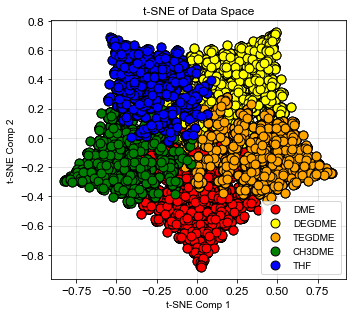

In [ ]:
fig,ax=plt.subplots(1,figsize=(5,4.5),facecolor='white')
ax.grid(color='gray',axis='both',alpha=0)
ax.set_axisbelow(True)

ax.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax.set_facecolor('none')

ax.grid(color='gray',axis='both',alpha=0.25)
ax.set_axisbelow(True)
ax.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=12)
ax.set_facecolor('none')
ax.set_ylabel('t-SNE Comp 2')
ax.set_xlabel('t-SNE Comp 1')

ax.set_title('t-SNE of Data Space')

#ax.set_xlim(-1,1.5)
#ax.set_ylim(-1,1)

ax.scatter(tsne_result['TC1'], tsne_result['TC2'], edgecolors='black', c = 'w',  s=80, marker='o')
ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 1]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 1]['TC2'], edgecolors='black', c = 'red',  s=80, marker='o', label='DME')
ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 2]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 2]['TC2'], edgecolors='black', c = 'yellow',  s=80, marker='o', label='DEGDME')
ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 3]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 3]['TC2'], edgecolors='black', c = 'orange',  s=80, marker='o', label='TEGDME')
ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 4]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 4]['TC2'], edgecolors='black', c = 'green',  s=80, marker='o', label='CH3DME')
ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 5]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 5]['TC2'], edgecolors='black', c = 'blue',  s=80, marker='o', label='THF')

# ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 6]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 6]['TC2'], edgecolors='black', c = 'violet',  s=80, marker='o', label='DME')
# ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 7]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 7]['TC2'], edgecolors='black', c = 'white',  s=80, marker='o', label='DEGDME')
# ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 8]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 8]['TC2'], edgecolors='black', c = 'gray',  s=80, marker='o', label='TEGDME')
# ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 9]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 9]['TC2'], edgecolors='black', c = 'black',  s=80, marker='o', label='CH3DME')
# ax.scatter(Data_Space_10_L.loc[Data_Space_10_L['Label'] == 10]['TC1'], Data_Space_10_L.loc[Data_Space_10_L['Label'] == 10]['TC2'], edgecolors='black', c = 'pink',  s=80, marker='o', label='THF')

#cbar = plt.colorbar(location='right', shrink = 1, pad=0.05)
#cbar.set_label(label='Log(1/(1 - Cycling Efficiency))', size=14)
#cbar.ax.tick_params(labelsize=12)
plt.legend()
plt.tight_layout()
#plt.savefig('Robustness Test/Data Space Projected onto 2 PCovs.png', dpi=600)
plt.show()

In [74]:
X_start = X_start.iloc[0:int(np.floor(185/Num_of_recs)*Num_of_recs)]
X_start['Log CE'] = X_start['<CE> (%)']
X_start['Iteration'] = np.array([[i]*int(Num_of_recs) for i in range(0,int((len(X_start)/Num_of_recs)))]).astype(int).flatten()

Iter_max = [0.0]*int((len(X_start)/Num_of_recs)+1)
for i in range(0,int((len(X_start)/Num_of_recs)+1)):
    Iter_max[i] = X_start.loc[X_start['Iteration'] <= i]['Log CE'].max()

X_start['CE'] = (1 - np.reciprocal(10**X_start['<CE> (%)']))*100

X_start_save = X_start.copy()

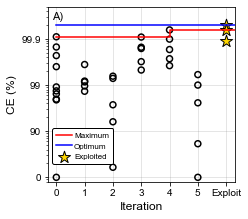

In [75]:
cm = 1/2.54
fig, ax = plt.subplots(1, figsize=(9*cm, 8*cm), facecolor='white')
ax.grid(color='gray', axis='both', alpha=0.25)
ax.set_axisbelow(True)

plt.scatter(X_start.loc[X_start['Iteration'] == 0]['Iteration'], np.reciprocal(1 - X_start.loc[X_start['Iteration'] == 0]['CE']/100), c='None', edgecolors='k', linewidths=1.5)
plt.scatter(X_start.loc[X_start['Iteration'] == 1]['Iteration']-1, np.reciprocal(1 - X_start.loc[X_start['Iteration'] == 1]['CE']/100), c='None', edgecolors='k', linewidths=1.5)

for i in range(2,int(L+2)):
    plt.scatter(X_start.loc[X_start['Iteration'] == i]['Iteration']-1, np.reciprocal(1 - X_start.loc[X_start['Iteration'] == i]['CE']/100), c='None', edgecolors='k', linewidths=1.5)

plt.scatter([L+1]*3, np.reciprocal(1 - Gaus_data.loc[Rec_points_pred_sorted.sort_values(by='Predicted CE', ascending=False)[:3].index]['CE']/100), marker='*', c='gold', edgecolors='k', linewidths=1, s=160, zorder=3, label='Exploited')
# plt.scatter(np.array([L+1]*3), np.reciprocal(1 - Gaus_data.loc[Rec_points_pred_sorted.sort_values(by='Predicted CE', ascending=False)[:3].index]['CE']/100), marker='.', c='k', edgecolors='k', linewidths=1, s=10, zorder=5)

plt.step(np.arange(0,int((len(X_start)/Num_of_recs)+1),1)[0:8], (10**np.array(Iter_max))[1:9], where='post', c='r', zorder=4, label='Maximum')
#plt.plot([0,37], [3.292429823902055,3.292429823902055], c='g')
plt.plot([0,L+2], [10**3.297774810522666,10**3.297774810522666], c='b', zorder=4, label='Optimum')
plt.xticks(np.arange(0,7,1), labels=['0','1','2','3','4','5','Exploit'], size=10)
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], labels=['0', '90', '99', '99.9', '99.99'])
plt.xlim(-0.3,L+1.3)
plt.ylim(0.8,5000)
plt.xlabel('Iteration', size=12)
plt.ylabel('CE (%)', size=12)
plt.annotate('A)', xy=(0.025,0.975), xycoords='axes fraction', size=11, ha='left', va='top')
plt.legend(bbox_to_anchor=(0.3709, 0.33), framealpha=1.0, edgecolor='k', labelspacing=0.5, handletextpad=0.25, borderpad=0.5, fontsize=8)
plt.tight_layout()
# plt.savefig('../Data/Exported Figures/Robustness Test - Iter 7 Ground Truth Model.png', dpi=600)

# 10 Average

In [15]:
seeds = [3,237,12,99,157,799,75,828,479,307] # For reproducibility
X_starts_10 = [0]*10
Recs_10 = [0]*10

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/si

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/si

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/si

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 9 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/l

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/py

TSNE


/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/294098519.py:157: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/294098519.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0', '68', '90', '96', '99', '99.7', '99.9', '99.97', '99.99'])
 50%|█████     | 5/10 [16:19<14:56, 179.29s/it]/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is clos

TSNE


/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/294098519.py:157: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/294098519.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0', '68', '90', '96', '99', '99.7', '99.9', '99.97', '99.99'])
 60%|██████    | 6/10 [17:32<09:33, 143.40s/it]/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/si

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/si

TSNE


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 1e+18. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3

TSNE


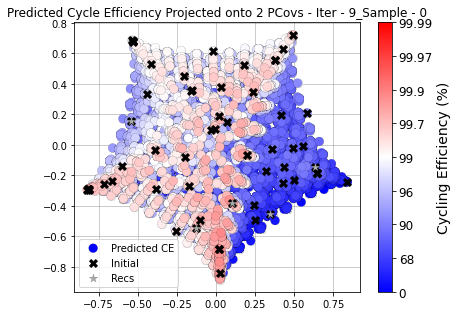

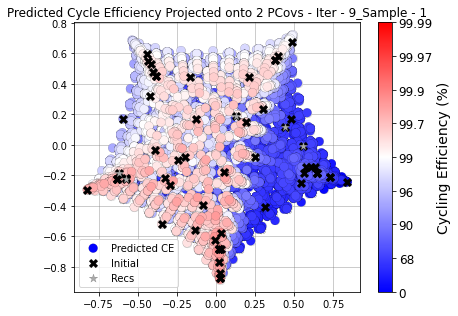

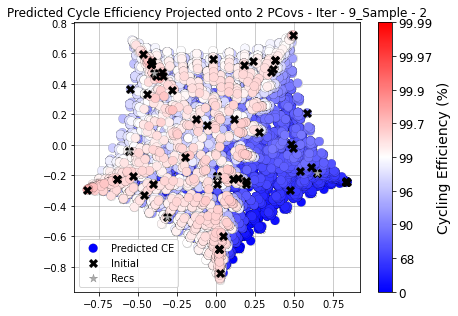

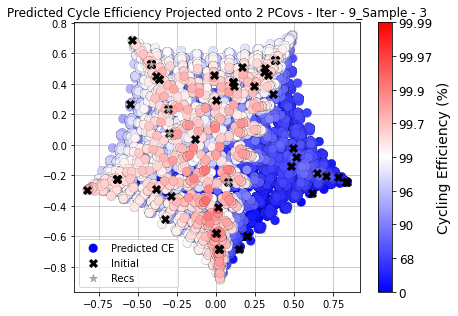

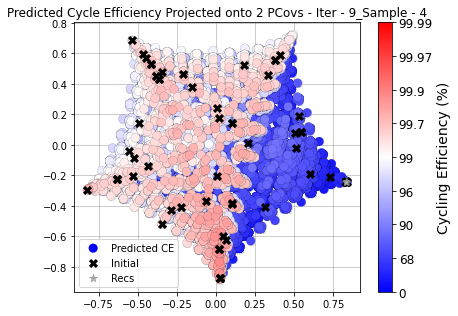

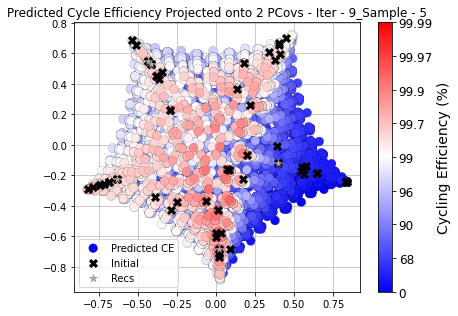

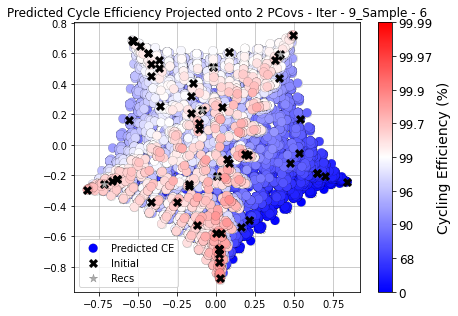

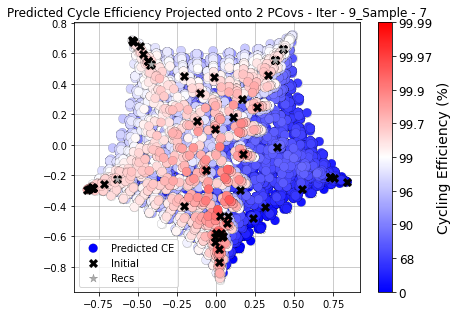

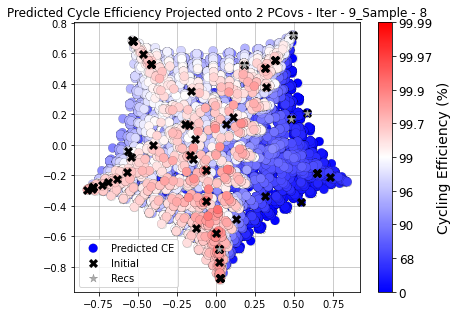

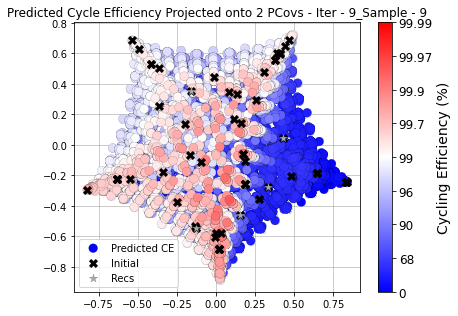

In [17]:
for P in tqdm(range(0,10)):    
    X_start = Gaus_data.sample(n=10, random_state=seeds[P])
    #X_start = Gaus_data.loc[((Gaus_data == 1).sum(axis=1) == 1)]
    #X_start = Initial.copy()
    X_s = X_scale.transform(X_start[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]) # Collected data transformed for GP modeling
    Y_s = Y_scale.transform(X_start[['<CE> (%)']]) # Scale for GP regression target

    Num_of_loops = 10
    for L in range(Num_of_loops):

        # Define GP model
        kernel_b = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
        Kernel = 1 * Matern(length_scale=1, length_scale_bounds=(0.1, 2), nu=1.5) + Wht(1.0, (1e-6, 1000))
        kernel_lit = C(1.0, (1e-3,1e3)) * matk([1.0]*10,[[1e-12, 1e18]]*10,1.5) + Wht(1.0, (1e-6, 1e3))
        Gaus_model = GaussianProcessRegressor(kernel=kernel_lit, n_restarts_optimizer=30, random_state=234)
        Gaus_model.fit(X_s,Y_s)

        # Predict CE and Uncertainty
        Pred, Std = Gaus_model.predict(Plotting_points_scaled, return_std = True)
        Pred_Next, Std_Next = Gaus_model.predict(Rec_points_scaled, return_std = True)
        ybest = X_start['<CE> (%)'].max()

        zzval=((Pred-ybest-epsilon)/Std)
        expI=(Pred-ybest-epsilon)*norm.cdf(zzval)+Std*norm.pdf(zzval)*weight

        for i in range(0,expI.shape[0]):
            if Std[i] < 0:
                expI[i] = 0

        # Get EI for next loop
        zzval_Next=((Pred_Next-ybest)/Std_Next)
        expI_Next=(Pred_Next-ybest-epsilon)*norm.cdf(zzval_Next)+Std_Next*norm.pdf(zzval_Next)*weight

        for i in range(0,expI_Next.shape[0]):
            if Std_Next[i] < 0:
                expI_Next[i] = 0

        # Copying data, predicting, and creating a sorted dataframe for plotting points
        Plotting_points_pred = Plotting_points.copy()
        Plotting_points_pred['Predicted CE'], Plotting_points_pred['Log Predicted CE StD'], Plotting_points_pred['Expected Improvement'] = (1-np.reciprocal(10**Y_scale.inverse_transform(Pred.reshape(-1, 1))))*100, Y_scale.inverse_transform(Std.reshape(-1, 1)) - Y_scale.mean_[0], expI.reshape(-1,1)
        Plotting_points_pred_sorted = Plotting_points_pred.copy().sort_values(by='Expected Improvement', ascending=True)

        # Copying data, predicting, and creating a sorted dataframe for recommending points
        Rec_points_pred = Rec_points.copy()
        Rec_points_pred['Predicted CE'], Rec_points_pred['Log Predicted CE StD'], Rec_points_pred['Expected Improvement'] = (1-np.reciprocal(10**Y_scale.inverse_transform(Pred_Next.reshape(-1, 1))))*100, Y_scale.inverse_transform(Std_Next.reshape(-1, 1)) - Y_scale.mean_[0], expI_Next.reshape(-1,1)
        Rec_points_pred_sorted = Rec_points_pred.copy().sort_values(by='Expected Improvement', ascending=True)

        # Creating dataset for farthest point sampling if needed
        FPS_Select_Scaled = pd.DataFrame(Rec_points_scaled, columns=Rec_points.columns) # Farthest point sampling in case it is needed later
        FPS_Select_Scaled['Predicted CE'], FPS_Select_Scaled['Log Predicted CE StD'], FPS_Select_Scaled['Expected Improvement'] = Y_scale.inverse_transform(Pred_Next.reshape(-1, 1)), Y_scale.inverse_transform(Std_Next.reshape(-1, 1)) - Y_scale.mean_[0], expI_Next.reshape(-1,1)

        # Check how many points are tied for the maximum EI and create data frame
        Maximum_EI_df = FPS_Select_Scaled.loc[np.round(Rec_points_pred['Expected Improvement'],3) == np.round(Rec_points_pred['Expected Improvement'].max(), 3)].copy().drop(['Predicted CE', 'Log Predicted CE StD', 'Expected Improvement'], axis=1).reset_index(drop=True)
        Maximum_EI_df_full = Rec_points_pred.loc[np.round(Rec_points_pred['Expected Improvement'],3) == np.round(Rec_points_pred['Expected Improvement'].max(), 3)].copy().reset_index(drop=True)

        # Break ties with furthest point sampling
        if Maximum_EI_df.shape[0] > Num_of_recs:

            FPS_points_full = Rec_points_pred.loc[Rec_points_pred['Expected Improvement'] == Rec_points_pred['Expected Improvement'].max()].copy().iloc[0:1]

            FPS_points = pd.DataFrame(X_s, columns=Plotting_points.columns)

            for i in range(0,Num_of_recs):
                distances = np.zeros(Maximum_EI_df.shape[0])
                for j in range(0,Maximum_EI_df.shape[0]):
                    temp = Maximum_EI_df.iloc[j].to_numpy().reshape(1,10) - FPS_points  
                    distances[j] = np.min(np.sum(np.square(temp), axis=1))
                max_idx = np.argmax(distances)
                FPS_points = pd.concat((FPS_points, Maximum_EI_df.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

                FPS_points_full = pd.concat((FPS_points_full, Maximum_EI_df_full.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

            Recs = FPS_points_full.reset_index(drop=True).iloc[-Num_of_recs:].sort_values(by='Expected Improvement', ascending=False).reset_index(drop=True)
                
        else:
            Recs = Rec_points_pred_sorted.iloc[-Num_of_recs:].sort_values(by='Expected Improvement', ascending=False).reset_index(drop=True)

        #Recs.to_excel('Robustness Test/Recs - ' + 'epsilon ' + str(epsilon) + ' weight ' + str(weight) + ' Iter - '+str(L)+'.xlsx')


        # Generate top 3 predictions:

        #all points sorted by CE, equivalent to Rec_points_pred_sorted
        CE_sortlist = Rec_points_pred.copy().sort_values(by='Predicted CE', ascending=True)

        #df of scaled parameter space for the compositions with max CE,
        Maximum_CE_df_full = Rec_points_pred.loc[np.round(Rec_points_pred['Predicted CE'],3) == np.round(Rec_points_pred['Predicted CE'].max(), 3)].copy().reset_index(drop=True)

        #above df with predictions dropped
        Maximum_CE_df = Maximum_CE_df_full.copy().drop(['Predicted CE', 'Log Predicted CE StD', 'Expected Improvement'], axis=1).reset_index(drop=True)

        if Maximum_CE_df.shape[0] > 3: #if there are more than 3 top entries, proceed with FPS

            FPS_points_full = Rec_points_pred.loc[Rec_points_pred['Predicted CE'] == Rec_points_pred['Predicted CE'].max()].copy().iloc[0:1]

            FPS_points = pd.DataFrame(X, columns=Plotting_points.columns)

            for i in range(0,3):
                distances = np.zeros(Maximum_CE_df.shape[0])
                for j in range(0,Maximum_CE_df.shape[0]):
                    temp = Maximum_CE_df.iloc[j].to_numpy().reshape(1,10) - FPS_points  
                    distances[j] = np.min(np.sum(np.square(temp), axis=1))
                max_idx = np.argmax(distances)
                FPS_points = pd.concat((FPS_points, Maximum_CE_df.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

                FPS_points_full = pd.concat((FPS_points_full, Maximum_CE_df_full.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

            top3Recs = FPS_points_full.reset_index(drop=True).iloc[-3:].sort_values(by='Predicted CE', ascending=False).reset_index(drop=True)
                
        else:
            top3Recs = CE_sortlist.iloc[-3:].sort_values(by='Predicted CE', ascending=False).reset_index(drop=True)

        # print(top3Recs)

        # Export Recs
        top3Recs.to_excel('../Data/Robustness Test/10 Rand/top3 - Iter - '+str(L)+'_Sample - '+str(P)+'.xlsx')

        # Visualize
        # Fit tSNE (tSNE)

        X_start = pd.concat((X_start,Recs.merge(Gaus_data, on=['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL'])))

        X_s = X_scale.transform(X_start[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]) # Collected data transformed for GP modeling
        Y_s = Y_scale.transform(X_start[['<CE> (%)']]) # Scale for GP regression target


    # Transform data
    T_pcovr_df =  space_labeled[["TC1","TC2"]].copy()

    T_pcovr_df['CE'] = Y_scale.inverse_transform(Pred.reshape(-1, 1))

    T_pcovr_df = T_pcovr_df.sort_values(by='CE', ascending=True)

    X_pcovr_df = X_start.copy().merge(space_labeled, on = ['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL'])

    Rec_pcovr_df = Recs.merge(space_labeled, on = ['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL'])

    # Export PCovR Axes
    #pd.DataFrame(data={'Component': Recs.columns[:10], 'PCov1': pcovr.components_[0], 'PCov2': pcovr.components_[1]}).to_excel('PCovR Components.xlsx')

    fig,ax=plt.subplots(1,figsize=(6,4.5), facecolor='white')
    ax.grid(color='gray',axis='both',alpha=0.5)
    ax.set_axisbelow(True)

    cm = plt.cm.get_cmap('plasma_r')

    sc = plt.scatter(T_pcovr_df['TC1'], T_pcovr_df['TC2'], s=80, c='white', edgecolors='k', linewidths=0.1, vmax = 102, vmin = 98, alpha=1)


    #sd2 = plt.scatter(X_pcovr_df['PC1'][24:50], X_pcovr_df['PC2'][24:50], s=16, c='None', edgecolors='k', linewidths=0.5, marker='^', label='1st Iter')
    sd3 = plt.scatter(T_pcovr_df['TC1'], T_pcovr_df['TC2'], s=80, c=T_pcovr_df['CE'], edgecolors='k', linewidths=0.1, marker='o', label='Predicted CE', vmax=4, vmin=0, cmap='bwr')

    cbar = plt.colorbar(location='right', shrink = 1, pad=0.05)
    cbar.set_label(label='Cycling Efficiency (%)', size=14)
    cbar.ax.set_yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])
    cbar.ax.set_yticklabels(['0', '68', '90', '96', '99', '99.7', '99.9', '99.97', '99.99'])
    cbar.ax.tick_params(labelsize=12)

    #sd = plt.scatter(X_pcovr_df['PC1'][24:], X_pcovr_df['PC2'][24:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s')
    sd1 = plt.scatter(X_pcovr_df['TC1'][:100], X_pcovr_df['TC2'][:100], s=80, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial')
    #se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1)
    sf = plt.scatter(Rec_pcovr_df.iloc[:12]['TC1'], Rec_pcovr_df.iloc[:12]['TC2'], s=80, c='darkgray', edgecolors='k', linewidths=0.1, label='Recs', marker='*')

    plt.title('Predicted Cycle Efficiency Projected onto 2 PCovs - Iter - '+str(L)+'_Sample - '+str(P))



    n = Gaus_data[:5].index + 1

    for i, txt in enumerate(n):
        plt.annotate(txt, (X_pcovr_df['TC1'][i]+0.005, X_pcovr_df['TC2'][i]+0.00000005), size=6, zorder=10)

    #plt.xlim(-6,4)
    #plt.ylim(-0.0000025,0.0000025)

    plt.legend()
    plt.tight_layout()

    #plt.savefig('../Data/Robustness Test/Data Space Projected onto 2 PCovs - Iter - '+str(L)+'.png', dpi=600)
    # plt.show()

    X_starts_10[P] = X_start
    Recs_10[P] = Rec_points_pred_sorted

In [18]:
Iter_max_10 = [0]*10
Exploits = [0]*10

for P in range(0,10):    
    X_starts_10[P] = X_starts_10[P].iloc[0:int(np.floor(185/Num_of_recs)*Num_of_recs)]
    X_starts_10[P]['Log CE'] = X_starts_10[P]['<CE> (%)']
    X_starts_10[P]['Iteration'] = np.array([[i]*int(Num_of_recs) for i in range(0,int((len(X_starts_10[P])/Num_of_recs)))]).astype(int).flatten()

    Iter_max_10[P] = [0.0]*int((len(X_starts_10[P])/Num_of_recs)+1)
    for i in range(0,int((len(X_starts_10[P])/Num_of_recs)+1)):
        Iter_max_10[P][i] = X_starts_10[P].loc[X_starts_10[P]['Iteration'] <= i]['Log CE'].max()
        
    Exploits[P] = np.reciprocal(1 - Gaus_data.loc[Recs_10[P].sort_values(by='Predicted CE', ascending=False)[:3].index]['CE']/100)

Exploits = np.array(Exploits)
means = np.mean(Iter_max_10, axis=0)
stds = np.std(Iter_max_10, axis=0)


/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/315681694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_starts_10[P]['Log CE'] = X_starts_10[P]['<CE> (%)']
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_84341/315681694.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_starts_10[P]['Iteration'] = np.array([[i]*int(Num_of_recs) for i in range(0,int((len(X_starts_10[P])/Num_of_recs)))]).astype(int).flatten()


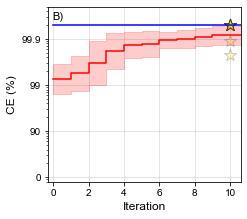

In [ ]:
cm = 1/2.54
fig, ax = plt.subplots(1, figsize=(9*cm, 8*cm), facecolor='white')
ax.grid(color='gray', axis='both', alpha=0.25)
ax.set_axisbelow(True)

# for P in range(0,10):
#     plt.scatter(X_starts_10[P].loc[X_starts_10[P]['Iteration'] == 0]['Iteration'], np.reciprocal(1 - X_starts_10[P].loc[X_starts_10[P]['Iteration'] == 0]['CE']/100), c='None', edgecolors='k', linewidths=1.5)
#     plt.scatter(X_starts_10[P].loc[X_starts_10[P]['Iteration'] == 1]['Iteration']-1, np.reciprocal(1 - X_starts_10[P].loc[X_starts_10[P]['Iteration'] == 1]['CE']/100), c='None', edgecolors='k', linewidths=1.5)

#     for i in range(2,int(L+2)):
#         plt.scatter(X_starts_10[P].loc[X_starts_10[P]['Iteration'] == i]['Iteration']-1, np.reciprocal(1 - X_starts_10[P].loc[X_starts_10[P]['Iteration'] == i]['CE']/100), c='None', edgecolors='k', linewidths=1.5)

#     plt.scatter([L+1]*1, np.reciprocal(1 - Gaus_data.loc[Recs_10[P].sort_values(by='Predicted CE', ascending=False)[:1].index]['CE']/100), marker='*', c='gold', edgecolors='k', linewidths=1, s=160, zorder=3, label='Exploited')
#     plt.scatter(np.array([L+1]*3), np.reciprocal(1 - Gaus_data.loc[Recs_10[P].sort_values(by='Predicted CE', ascending=False)[:3].index]['CE']/100), marker='.', c='k', edgecolors='k', linewidths=1, s=10, zorder=5)

#     plt.step(np.arange(0,int((len(X_starts_10[P])/Num_of_recs)+1),1)[0:12], (10**np.array(Iter_max_10[P]))[1:13], where='post', c='r', zorder=4, label='Maximum')


plt.scatter([L+1]*10, Exploits.max(axis=1), marker='*', c='gold', edgecolors='k', linewidths=1, s=160, zorder=3, label='Exploited', alpha=0.2)
plt.step(np.arange(0,int((len(X_starts_10[P])/Num_of_recs)+1),1)[0:12], 10**means[1:13], where='post', c='r', zorder=4, label='Maximum')
plt.fill_between(np.arange(0,int((len(X_starts_10[P])/Num_of_recs)+1),1)[0:12], 10**(means+stds)[1:13], 10**(means-stds)[1:13], alpha=0.2, step='post', color='r')
#plt.plot([0,37], [3.292429823902055,3.292429823902055], c='g')

plt.plot([0,L+2], [10**3.297774810522666,10**3.297774810522666], c='b', zorder=4, label='Optimum')
#plt.xticks(np.arange(0,7,1), labels=['0','1','2','3','4','5','Exploit'], size=10)
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], labels=['0', '90', '99', '99.9', '99.99'])
plt.xlim(-0.3,L+1.6)
plt.ylim(0.8,5000)
plt.xlabel('Iteration', size=12)
plt.ylabel('CE (%)', size=12)
plt.annotate('B)', xy=(0.025,0.975), xycoords='axes fraction', size=11, ha='left', va='top')
#plt.legend(bbox_to_anchor=(0.709, 0.33), framealpha=1.0, edgecolor='k', labelspacing=0.5, handletextpad=0.25, borderpad=0.5, fontsize=8)
plt.tight_layout()
# plt.savefig('../Data/Robustness Test/Robustness Test - Iter 7 Ground Truth Model - 10 Iters - 10 Reps.png', dpi=600)

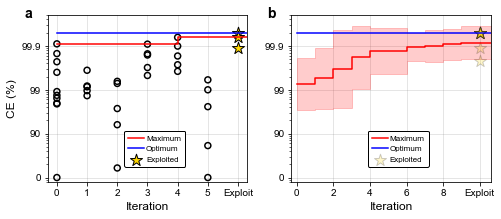

In [ ]:
cm = 1/2.54
fig, ax = plt.subplot_mosaic("AB", figsize=(18*cm, 8*cm), facecolor='white')

plt.rcParams['font.family'] = 'Arial'

ax['A'].grid(color='gray', axis='both', alpha=0.25)
ax['B'].grid(color='gray', axis='both', alpha=0.25)
ax['A'].set_axisbelow(True)
ax['B'].set_axisbelow(True)


ax['A'].scatter(X_start_save.loc[X_start_save['Iteration'] == 0]['Iteration'], np.reciprocal(1 - X_start_save.loc[X_start_save['Iteration'] == 0]['CE']/100), c='None', edgecolors='k', linewidths=1.5)
ax['A'].scatter(X_start_save.loc[X_start_save['Iteration'] == 1]['Iteration']-1, np.reciprocal(1 - X_start_save.loc[X_start_save['Iteration'] == 1]['CE']/100), c='None', edgecolors='k', linewidths=1.5)

for i in range(2,int(L+2)):
    ax['A'].scatter(X_start_save.loc[X_start_save['Iteration'] == i]['Iteration']-1, np.reciprocal(1 - X_start_save.loc[X_start_save['Iteration'] == i]['CE']/100), c='None', edgecolors='k', linewidths=1.5)

ax['A'].scatter([L+1]*3, np.reciprocal(1 - Gaus_data.loc[Rec_points_pred_sorted.sort_values(by='Predicted CE', ascending=False)[:3].index]['CE']/100), marker='*', c='gold', edgecolors='k', linewidths=1, s=160, zorder=3, label='Exploited')
#ax['A'].scatter(np.array([L+1]*3), np.reciprocal(1 - Gaus_data.loc[Rec_points_pred_sorted.sort_values(by='Predicted CE', ascending=False)[:3].index]['CE']/100), marker='.', c='k', edgecolors='k', linewidths=1, s=10, zorder=5)

ax['A'].step(np.arange(0,int((len(X_start_save)/Num_of_recs)+1),1)[0:8], (10**np.array(Iter_max))[1:9], where='post', c='r', zorder=4, label='Maximum')
#plt.plot([0,37], [3.292429823902055,3.292429823902055], c='g')
ax['A'].plot([0,L+2], [10**3.297774810522666,10**3.297774810522666], c='b', zorder=4, label='Optimum')
ax['A'].set_xticks(np.arange(0,7,1))
ax['A'].set_xticklabels(labels=['0','1','2','3','4','5','Exploit'], size=10)
ax['A'].set_yscale('log')
ax['A'].set_yticks([1, 10, 100, 1000, 10000])
ax['A'].set_yticklabels(labels=['0', '90', '99', '99.9', '99.99'], size=10)
ax['A'].set_xlim(-0.3,L+1.3)
ax['A'].set_ylim(0.8,5000)
ax['A'].set_xlabel('Iteration', size=12)
ax['A'].set_ylabel('CE (%)', size=12)
ax['A'].annotate('a', xy=(-0.1,1.05), xycoords='axes fraction', size=14, ha='center', va='top', fontweight="bold", fontfamily="Arial")
ax['A'].legend(bbox_to_anchor=(0.709, 0.33), framealpha=1.0, edgecolor='k', labelspacing=0.5, handletextpad=0.25, borderpad=0.5, fontsize=8)






ax['B'].scatter([9+1]*10, Exploits.max(axis=1), marker='*', c='gold', edgecolors='k', linewidths=1, s=160, zorder=3, label='Exploited', alpha=0.2)
ax['B'].step(np.arange(0,int((len(X_starts_10[P])/Num_of_recs)+1),1)[0:12], 10**means[1:13], where='post', c='r', zorder=4, label='Maximum')
ax['B'].fill_between(np.arange(0,int((len(X_starts_10[P])/Num_of_recs)+1),1)[0:12], 10**(means+stds*1.833)[1:13], 10**(means-stds*1.833)[1:13], alpha=0.2, step='post', color='r')
#plt.plot([0,37], [3.292429823902055,3.292429823902055], c='g')

ax['B'].plot([0,9+2], [10**3.297774810522666,10**3.297774810522666], c='b', zorder=4, label='Optimum')
#plt.xticks(np.arange(0,7,1), labels=['0','1','2','3','4','5','Exploit'], size=10)
ax['B'].set_yscale('log')
ax['B'].set_yticks([1, 10, 100, 1000, 10000])
ax['B'].set_yticklabels(labels=['0', '90', '99', '99.9', '99.99'], size=10)
ax['B'].set_xticks(np.arange(0,11,2))
ax['B'].set_xticklabels(labels=['0','2','4','6','8','Exploit'], size=10)
ax['B'].set_xlim(-0.3,9+1.6)
ax['B'].set_ylim(0.8,5000)
ax['B'].set_xlabel('Iteration', size=12)
#ax['B'].set_ylabel('CE (%)', size=12)
ax['B'].annotate('b', xy=(-0.1,1.05), xycoords='axes fraction', size=14, ha='center', va='top', fontweight="bold", fontfamily="Arial")
ax['B'].legend(bbox_to_anchor=(0.709, 0.33), framealpha=1.0, edgecolor='k', labelspacing=0.5, handletextpad=0.25, borderpad=0.5, fontsize=8)
plt.tight_layout()
# plt.savefig('../Data/Exported Figures/Robustness Test - Ground Truth Model.png', dpi=600)